In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import LMRt

import matplotlib.pyplot as plt
from matplotlib import gridspec                                                           
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature                                                        

from spharm import Spharmt, regrid

from tqdm import tqdm
import string

from scipy.io import loadmat

## Load data

In [2]:
exp_dict = {
    'LMR (Corals)': '../recons/recon_Corals.nc',
    'LMR (Li13b6)': '../recons/recon_Li13b6.nc',
    'LMR (Corals+Li13b6)': '../recons/recon_COrals_Li13b6.nc',
}

ref_dict = {
    'ERSSTv5': '../data/ERSSTv5_sst_DJF.nc',
}

In [3]:
tas = {}
nino34 = {}
lat = {}
lon = {}
year = {}
for exp_tag, path in exp_dict.items():
    with xr.open_dataset(path) as ds:
        tas[exp_tag] = ds['tas'].values
        nino34[exp_tag] = ds['nino34'].values
        lat[exp_tag] = ds['lat'].values
        lon[exp_tag] = ds['lon'].values
        year[exp_tag] = ds['year'].values
        
for ref_tag, path in ref_dict.items():
    with xr.open_dataset(path) as ds:
        tas[ref_tag] = ds['tas'].values
        lat[ref_tag] = ds['lat'].values
        lon[ref_tag] = ds['lon'].values
        year[ref_tag] = ds['year'].values

In [4]:
exp_tag = 'LMR (Corals)'
print(np.shape(tas[exp_tag]))

(901, 42, 63)


In [5]:
# calculate NINO3.4 from ERSSTv5

ref_tag = 'ERSSTv5'
print(np.shape(tas[ref_tag]))
nino34_ERSSTv5 = LMRt.utils.nino_indices(tas[ref_tag], lat[ref_tag], lon[ref_tag])['nino3.4']
print(np.shape(nino34_ERSSTv5))

(165, 89, 180)
(165,)


In [6]:
for exp_tag, path in exp_dict.items():
    yr_min = np.min(year[exp_tag])
    yr_max = np.max(year[exp_tag])
    print(exp_tag, ':', yr_min, yr_max)
    
for ref_tag, path in ref_dict.items():
    yr_min = np.min(year[ref_tag])
    yr_max = np.max(year[ref_tag])
    print(ref_tag, ':', yr_min, yr_max)

LMR (Corals) : 1100 2000
LMR (Li13b6) : 1100 2000
LMR (Corals+Li13b6) : 1100 2000
ERSSTv5 : 1855 2019


## Calculation

In [7]:
# calculate correlation between LMR recons and ERSSTv5

verif_s, verif_e = 1881, 2000
verif_yrs = np.arange(verif_s, verif_e+1)

valid_frac = 0.5

ref_tag = 'ERSSTv5'
nlat_ref, nlon_ref = np.size(lat[ref_tag]), np.size(lon[ref_tag])
spec_ref = Spharmt(nlon_ref, nlat_ref, gridtype='regular', legfunc='computed')

ind_ref = [list(year[ref_tag]).index(y) for y in verif_yrs]
nt = len(ind_ref)

corr = {}
for exp_tag in tqdm(['LMR (Corals)', 'LMR (Li13b6)', 'LMR (Corals+Li13b6)']):
    # interpolate recons. onto the instrumental observation
    nlat_lmr, nlon_lmr = np.size(lat[exp_tag]), np.size(lon[exp_tag])
    spec_lmr = Spharmt(nlon_lmr, nlat_lmr, gridtype='regular', legfunc='computed')
    
    ind_lmr = [list(year[exp_tag]).index(y) for y in verif_yrs]
    
    lmr_on_ref = []
    for i in ind_lmr:
        lmr_on_ref.append(
            regrid(spec_lmr, spec_ref, tas[exp_tag][i], ntrunc=None, smooth=None)
        )
        
    lmr_on_ref = np.array(lmr_on_ref)
    
    # calculate correlation at each grid cell
    corr[exp_tag] = np.ndarray((nlat_ref, nlon_ref))
    for i in range(nlat_ref):
        for j in range(nlon_ref):
            ts_ref = tas[ref_tag][ind_ref,i,j]
            ts_lmr = lmr_on_ref[:,i,j]
            
            ts_ref_notnan = ts_ref[~np.isnan(ts_ref)]
            ts_lmr_notnan = ts_lmr[~np.isnan(ts_ref)]
            nt_notnan = np.shape(ts_ref_notnan)[0]
            
            if nt_notnan/nt >= valid_frac:
                corr[exp_tag][i, j] = np.corrcoef(ts_ref_notnan, ts_lmr_notnan)[1, 0]
            else:
                corr[exp_tag][i, j] = np.nan

  0%|          | 0/3 [00:00<?, ?it/s]/Users/fzhu/Apps/miniconda3/envs/LMRt/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fzhu/Apps/miniconda3/envs/LMRt/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


In [8]:
# load proxy locations
with open('../data/proxy_locs.pkl', 'rb') as f:
    site_lats, site_lons = pickle.load(f)
    
site_color = {
    'Corals': sns.xkcd_rgb['amber'],
    'NADA': sns.xkcd_rgb['mint'],
    'MADA': sns.xkcd_rgb['baby blue'],
    'Kauri': sns.xkcd_rgb['medium green'],
    'SAAltiplano': sns.xkcd_rgb['medium green'],
}

site_marker = {
    'Corals': 'o',
    'NADA': 's',
    'MADA': 's',
    'Kauri': '^',
    'SAAltiplano': 'v',
}

## Visualization

<ipython-input-9-980450345c4d>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Reds").copy()
  cmap.set_under('white')
3it [00:00, 54.45it/s]


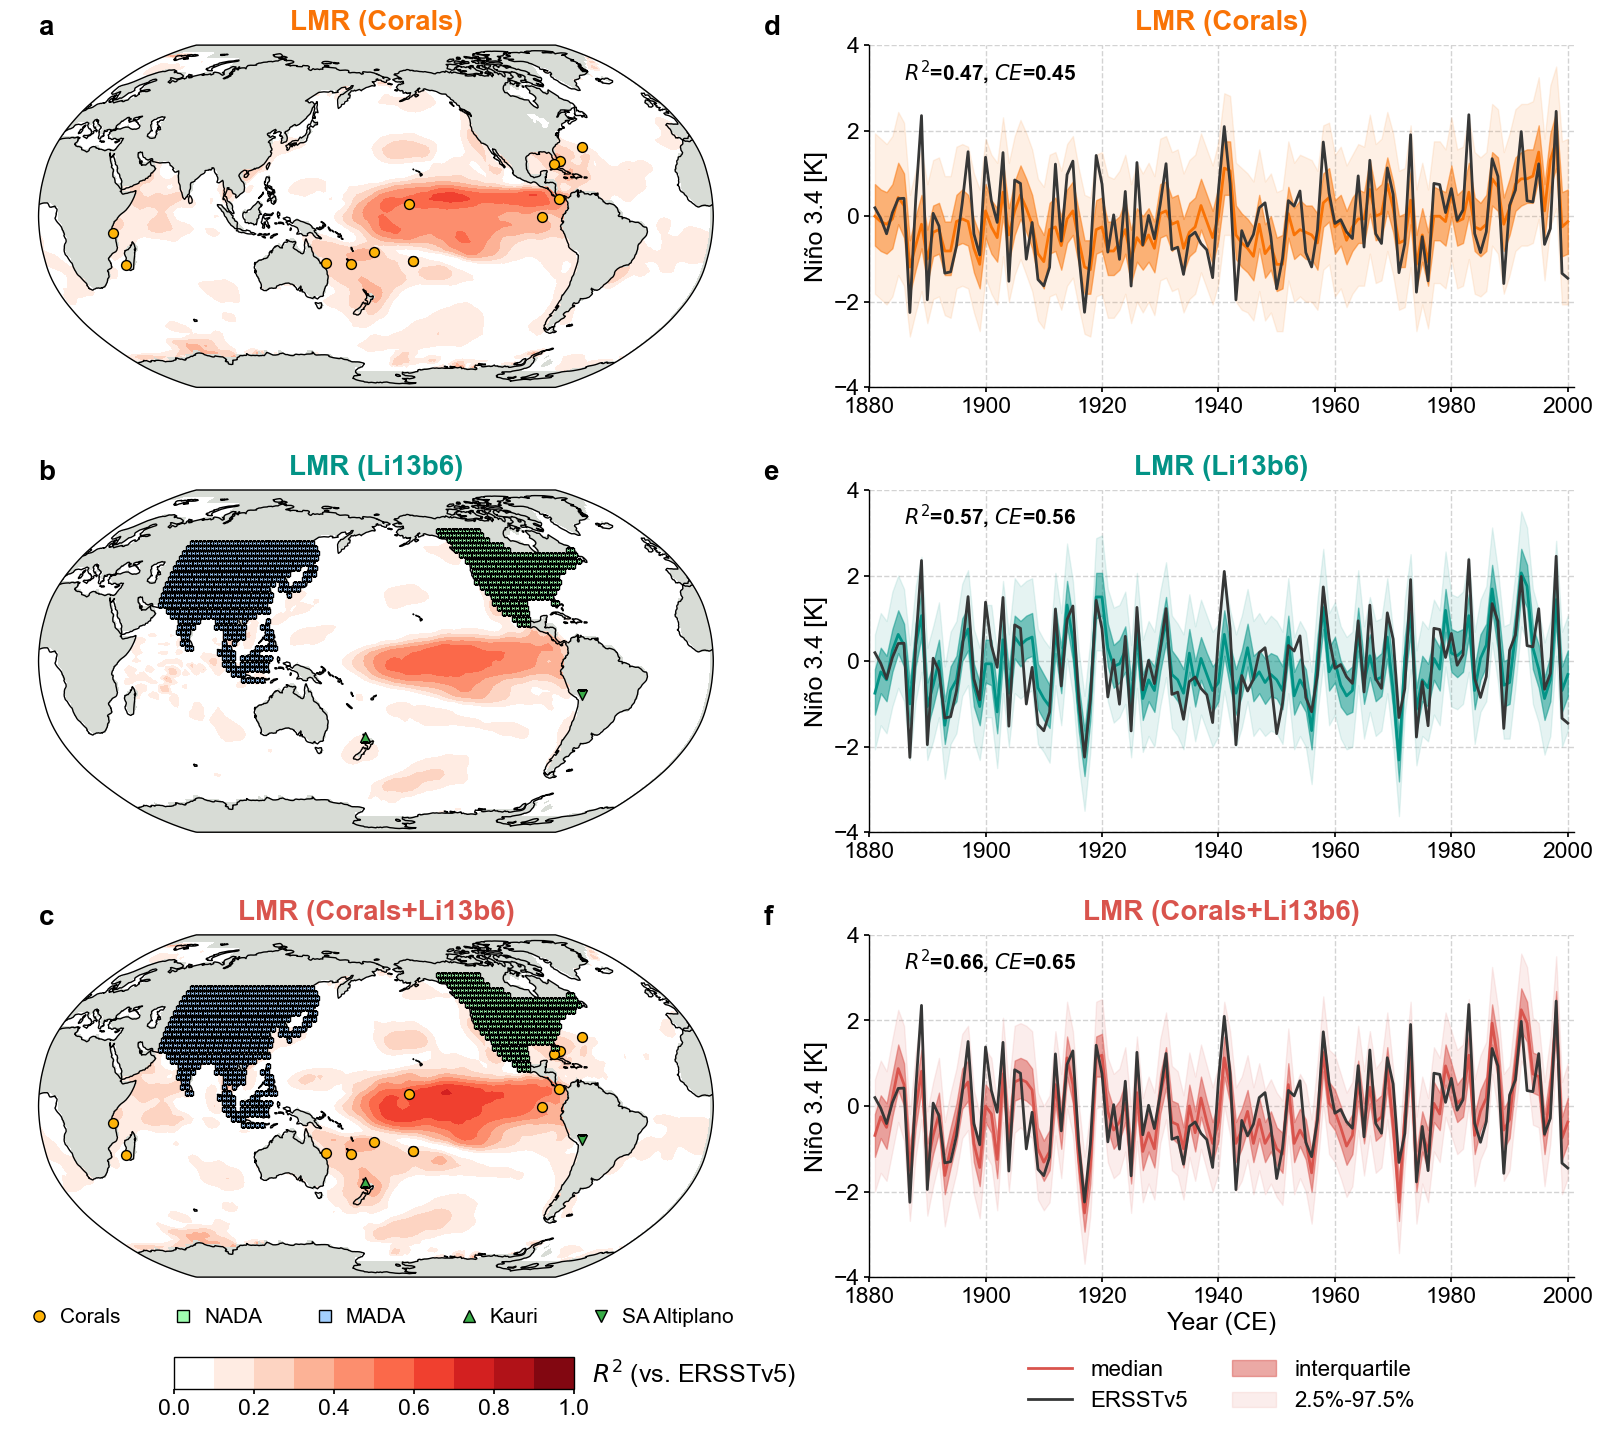

Figure saved at: "../figs/Fig-1.pdf"


In [9]:
LMRt.set_style('journal', font_scale=1.5)

land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['light grey']


fig = plt.figure(figsize=[20, 16])
gs = gridspec.GridSpec(3, 2)                                                   
gs.update(wspace=0.2, hspace=0.3)

exp_color = {
    'LMR (Corals)': sns.xkcd_rgb['orange'],
    'LMR (Li13b6)': sns.xkcd_rgb['teal'],
    'LMR (Corals+Li13b6)': sns.xkcd_rgb['pale red'],
}

exp_proxy = {
    'LMR (Corals)': ['Corals'],
    'LMR (Li13b6)': ['NADA', 'MADA', 'Kauri', 'SAAltiplano'],
    'LMR (Corals+Li13b6)': ['Corals', 'NADA', 'MADA', 'Kauri', 'SAAltiplano'],
}

ref_tag = 'ERSSTv5'
#=============================================
# SST field
#---------------------------------------------
projection = ccrs.Robinson(central_longitude=180)
levels = np.linspace(0, 1, 11)
clim=[0.1, 1]
extend='neither'
cmap = plt.get_cmap('Reds')
cmap.set_under('white')
transform=ccrs.PlateCarree()

ax = {}
for i, exp_tag in enumerate(exp_color.keys()):
#     ax[exp_tag] = plt.subplot(gs[i, :7], projection=projection)
    ax[exp_tag] = plt.subplot(gs[i, 0], projection=projection)
    ax[exp_tag].set_global()
    ax[exp_tag].add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
    ax[exp_tag].add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
    ax[exp_tag].coastlines()
    im = ax[exp_tag].contourf(
        lon[ref_tag], lat[ref_tag], corr[exp_tag]**2,
        levels, transform=transform, cmap=cmap, extend=extend
    )
    im.set_clim(clim)
    
    for proxy_name in site_lats.keys():
        if proxy_name in exp_proxy[exp_tag]:
            ms = 10 if proxy_name in ['NADA', 'MADA'] else 50
            ec = 'k'
            ax[exp_tag].scatter(
                site_lons[proxy_name], site_lats[proxy_name], s=ms,
                c=site_color[proxy_name], marker=site_marker[proxy_name], edgecolors=ec,
                zorder=99, transform=transform
            )
    
    ax[exp_tag].set_title(exp_tag, color=exp_color[exp_tag], fontweight='bold', y=1.02, fontsize=20)
    
# legend
ms = 8

marker_Corals = mlines.Line2D(
    [], [], markerfacecolor=site_color['Corals'], markeredgecolor='k',
    marker='o', linestyle='None', markersize=ms, label='Corals'
)
marker_NADA = mlines.Line2D(
    [], [], markerfacecolor=site_color['NADA'], markeredgecolor='k',
    marker='s', linestyle='None', markersize=ms, label='NADA'
)
marker_MADA = mlines.Line2D(
    [], [], markerfacecolor=site_color['MADA'], markeredgecolor='k',
    marker='s', linestyle='None', markersize=ms, label='MADA'
)
marker_Kauri = mlines.Line2D(
    [], [], markerfacecolor=site_color['Kauri'], markeredgecolor='k',
    marker='^', linestyle='None', markersize=ms, label='Kauri'
)
marker_SAA = mlines.Line2D(
    [], [], markerfacecolor=site_color['SAAltiplano'], markeredgecolor='k',
    marker='v', linestyle='None', markersize=ms, label='SA Altiplano'
)

ax[exp_tag].legend(
    handles=[marker_Corals, marker_NADA, marker_MADA, marker_Kauri, marker_SAA],
    frameon=False,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    fontsize=15,
    handletextpad=0.01,
    ncol=5,
)

# colorbar
cax = fig.add_axes([0.2, 0.04, 0.2, 0.02])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.ax.set_title(r'$R^2$ (vs. ERSSTv5)', x=1.3, y=-0.1)
#=============================================

#=============================================
# NINO3.4
#---------------------------------------------
ax_ts = {}
syr, eyr = 1881, 2000
for i, exp_tag in tqdm(enumerate(exp_color.keys())):
    # calculate correlation and CE between LMR recons and ERSSTv5
    mask = (year[exp_tag]>=syr) & (year[exp_tag]<=eyr)
    mask_ref = (year[ref_tag]>=syr) & (year[ref_tag]<=eyr)
    nino34_lmr = nino34[exp_tag][2, mask]
    nino34_ref = nino34_ERSSTv5[mask_ref]
    r = np.corrcoef(nino34_ref, nino34_lmr)[1, 0]
    ce = LMRt.utils.coefficient_efficiency(nino34_ref, nino34_lmr)
    
    # plot
    ax_ts[exp_tag] = plt.subplot(gs[i, 1])
    ax_ts[exp_tag].plot(year[exp_tag][mask], nino34[exp_tag][2, mask], color=exp_color[exp_tag], zorder=98, label='median')
    ax_ts[exp_tag].plot(year[ref_tag][mask_ref], nino34_ref, color=sns.xkcd_rgb['dark grey'], zorder=99, label='ERSSTv5')
    ax_ts[exp_tag].fill_between(
        year[exp_tag][mask], nino34[exp_tag][1, mask], nino34[exp_tag][-2, mask],
        color=exp_color[exp_tag], alpha=0.5, zorder=97, label='interquartile',
    )
    ax_ts[exp_tag].fill_between(
        year[exp_tag][mask], nino34[exp_tag][0, mask], nino34[exp_tag][-1, mask],
        color=exp_color[exp_tag], alpha=0.1, zorder=96, label='2.5%-97.5%',
    )
    
    ax_ts[exp_tag].set_ylabel('Niño 3.4 [K]')
    xlb = 'Year (CE)' if i==2 else None
    ax_ts[exp_tag].set_xlabel(xlb)
    ax_ts[exp_tag].set_ylim([-4, 4])
    ax_ts[exp_tag].set_xlim([syr-1, eyr+1])
    ax_ts[exp_tag].set_title(exp_tag, color=exp_color[exp_tag], fontweight='bold', y=1.02, fontsize=20)
    
    ax_ts[exp_tag].text(
        0.05, 0.9, fr'$R^2$={r**2:.2f}, $CE$={ce:.2f}',
        transform=ax_ts[exp_tag].transAxes, 
        size=15, weight='bold',
    )
    
# legend
ax_ts[exp_tag].legend(
    frameon=False,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.45),
    fontsize=16,
    ncol=2,
)

#=============================================

# annotation
fs = 20
for i, exp_tag in enumerate(exp_color.keys()):
    ax[exp_tag].text(
        0, 1.03, string.ascii_lowercase[i],
        transform=ax[exp_tag].transAxes, 
        size=fs, weight='bold',
    )
    
for i, exp_tag in enumerate(exp_color.keys()):
    ax_ts[exp_tag].text(
        -0.15, 1.03, string.ascii_lowercase[i+3],
        transform=ax_ts[exp_tag].transAxes, 
        size=fs, weight='bold',
    )
    
LMRt.showfig(fig)
LMRt.savefig(fig, '../figs/Fig-1.pdf')